In [1]:
import sys
import os
import pandas as pd


In [2]:
sys.path.append('..')

In [3]:
from icenode.train_icenode_2lr import ICENODE
from icenode.train_gram import GRAM
from icenode.train_retain import RETAIN

%load_ext autoreload
%autoreload 2

/home/asem/.conda/envs/icenode/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


## Define Directories

In [4]:
HOME = os.environ.get('HOME')

# MIMIC-III Dataset Directory
mimic3_dir = f'{HOME}/GP/ehr-data/mimic3-transforms'

# ICE-NODE/M trained on MIMIC-III training partition (70%)
icenode_m3_dir = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.09.aM3_icenode_2lr_M/trial_626'

# RETAIN trained on MIMIC-III training partition (70%)
# retain_m3_dir = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.1.23M3_retain_M/frozen_trial_142'

# # GRU=GRAM/M trained on MIMIC-III training partition (70%)
# gru_m3_dir = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.1.23M3_gram_M/frozen_trial_615'

# # GRAM=GRAM/G trained on MIMIC-III training partition (70%)
# gram_m3_dir = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.1.23M3_gram_G/frozen_trial_442'

## Patient Interface for each Model

In [5]:
icnode_patient_interface = ICENODE.create_patient_interface(mimic3_dir, 'M3')

2022-02-10 15:02:49.669219: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


## Dataset Partitioning

In [6]:
import random

# seed 42 is used in all our experiments in this work.
rng = random.Random(42)
subjects_id = list(icnode_patient_interface.subjects.keys())
rng.shuffle(subjects_id)

# splits = train:val:test = 0.7:.15:.15
splits = int(.7 * len(subjects_id)), int(.85 * len(subjects_id))

train_ids = subjects_id[:splits[0]]
valid_ids = subjects_id[splits[0]:splits[1]]
test_ids = subjects_id[splits[1]:]

## Load Configs and Trained Params

In [7]:
from icenode.utils import load_config, load_params

icenode_config = load_config(f'{icenode_m3_dir}/config.json')
icenode_params = load_params(f'{icenode_m3_dir}/step0100_params.pickle')

# retain_config = load_config(f'{retain_m3_dir}/config.json')
# retain_params = load_params(f'{retain_m3_dir}/step0100_params.pickle')

# gru_config = load_config(f'{gru_m3_dir}/config.json')
# gru_params = load_params(f'{gru_m3_dir}/step0100_params.pickle')

# gram_config = load_config(f'{gram_m3_dir}/config.json')
# gram_params = load_params(f'{gram_m3_dir}/step0100_params.pickle')

## Create Model Objects

In [8]:
icenode_config

{'emb': {'diag': {'embeddings_dim': 270}, 'kind': 'matrix'},
 'model': {'ode_dyn': 'mlp',
  'ode_init_var': 9.758245410190807e-07,
  'ode_with_bias': False,
  'state_size': 30,
  'timescale': 60},
 'training': {'batch_size': 17,
  'decay_rate1': 0.19491357038600624,
  'decay_rate2': 0.44115766777808035,
  'epochs': 20,
  'loss_mixing': {'L_dyn': 0, 'L_l1': 0, 'L_l2': 0},
  'lr1': 1.0024733027089936e-05,
  'lr2': 0.0013290335620369526,
  'optimizer': 'adam'}}

In [9]:
icenode = ICENODE.create_model(icenode_config, icnode_patient_interface, train_ids, None)
model_state = icenode.init_with_params(icenode_config, icenode_params)
# retain = RETAIN.create_model(retain_config, retain_patient_interface, train_ids, None)
# gru = GRAM.create_model(gru_config, gram_patient_interface, train_ids, None)
# gram = GRAM.create_model(gram_config, gram_patient_interface, train_ids, None)

In [10]:
code_partitions = ICENODE.code_partitions(icnode_patient_interface, train_ids) 

In [11]:
from icenode.metrics import evaluation_table
res = icenode.eval(model_state, test_ids)

In [12]:
eval_df = evaluation_table({'TST': res}, code_partitions)

/home/asem/.conda/envs/icenode/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5338: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


In [13]:
eval_df

(                           TST
 Kfe               5.121800e+01
 MACRO-AUC         9.443060e-01
 MICRO-AUC         9.457195e-01
 accuracy          8.424346e-01
 admissions_count  1.009000e+03
 dyn_loss          4.404681e-09
 f1-score          1.570507e-01
 fn                1.784490e-03
 fp                1.557809e-01
 loss              7.751823e-02
 nfe_per_week      8.135911e-01
 npv               9.978488e-01
 odeint_weeks      6.295300e+04
 pre_ACC-P0        1.516930e-01
 pre_ACC-P1        3.618888e-01
 pre_ACC-P2        4.584195e-01
 pre_ACC-P3        7.421875e-01
 pre_ACC-P4        9.426995e-01
 precision         8.610913e-02
 prediction_loss   7.751823e-02
 recall            8.916032e-01
 specificity       8.416116e-01
 tn                8.277565e-01
 tp                1.467808e-02,
 {'TST_loss': 0.07751823216676712,
  'TST_prediction_loss': 0.07751823216676712,
  'TST_dyn_loss': 4.404681064329452e-09,
  'TST_admissions_count': 1009.0,
  'TST_odeint_weeks': 62953.0,
  'TST_nfe_p

## Analyse AUC for Each Admission in the Test Partition

In [14]:
icenode_auc_df = icenode.admissions_auc_scores(model_state, test_ids)

In [15]:
icenode_auc_df

,SUBJECT_ID,HADM_ID,HADM_IDX,AUC,N_CODES,TIME,INTERVALS,LOS,NFE
0,19842,169734,0,0.968740,9.0,412.5,412.5,3.5,62.0
1,19842,186772,1,0.962465,16.0,433.5,21.0,7.5,26.0
2,19842,180229,2,0.975859,9.0,448.5,15.0,3.5,26.0
3,19842,122439,3,0.970373,13.0,509.5,61.0,7.5,32.0
4,19842,163738,4,0.992351,13.0,552.5,43.0,5.5,32.0
...,...,...,...,...,...,...,...,...,...
1004,26421,192868,1,0.974110,6.0,278.5,186.0,3.5,50.0
1005,2558,105758,0,0.889030,11.0,59.5,59.5,4.5,32.0
1006,2558,194247,1,0.975313,8.0,70.5,11.0,4.5,20.0
1007,10832,196835,0,0.972145,9.0,647.5,647.5,8.5,68.0


In [16]:
icenode_auc_df.to_csv('icenode_auc_df.csv')

In [17]:
icenode_auc_df['NFE'] = icenode_auc_df['NFE'].astype(int)
icenode_auc_df['NFEpday'] = icenode_auc_df['NFE'].astype(int) / icenode_auc_df['INTERVALS']
icenode_auc_df['N_CODES'] = icenode_auc_df['N_CODES'].astype(int)


In [18]:
icenode_auc_df.dtypes

SUBJECT_ID      int64
HADM_ID         int64
HADM_IDX        int64
AUC           float64
N_CODES         int64
TIME          float64
INTERVALS     float64
LOS           float64
NFE             int64
NFEpday       float64
dtype: object

In [19]:
icenode_stat = icenode_auc_df[['AUC', 'N_CODES', 'INTERVALS', 'LOS', 'NFE', 'NFEpday']]

In [20]:
icenode_stat

,AUC,N_CODES,INTERVALS,LOS,NFE,NFEpday
0,0.968740,9,412.5,3.5,62,0.150303
1,0.962465,16,21.0,7.5,26,1.238095
2,0.975859,9,15.0,3.5,26,1.733333
3,0.970373,13,61.0,7.5,32,0.524590
4,0.992351,13,43.0,5.5,32,0.744186
...,...,...,...,...,...,...
1004,0.974110,6,186.0,3.5,50,0.268817
1005,0.889030,11,59.5,4.5,32,0.537815
1006,0.975313,8,11.0,4.5,20,1.818182
1007,0.972145,9,647.5,8.5,68,0.105019


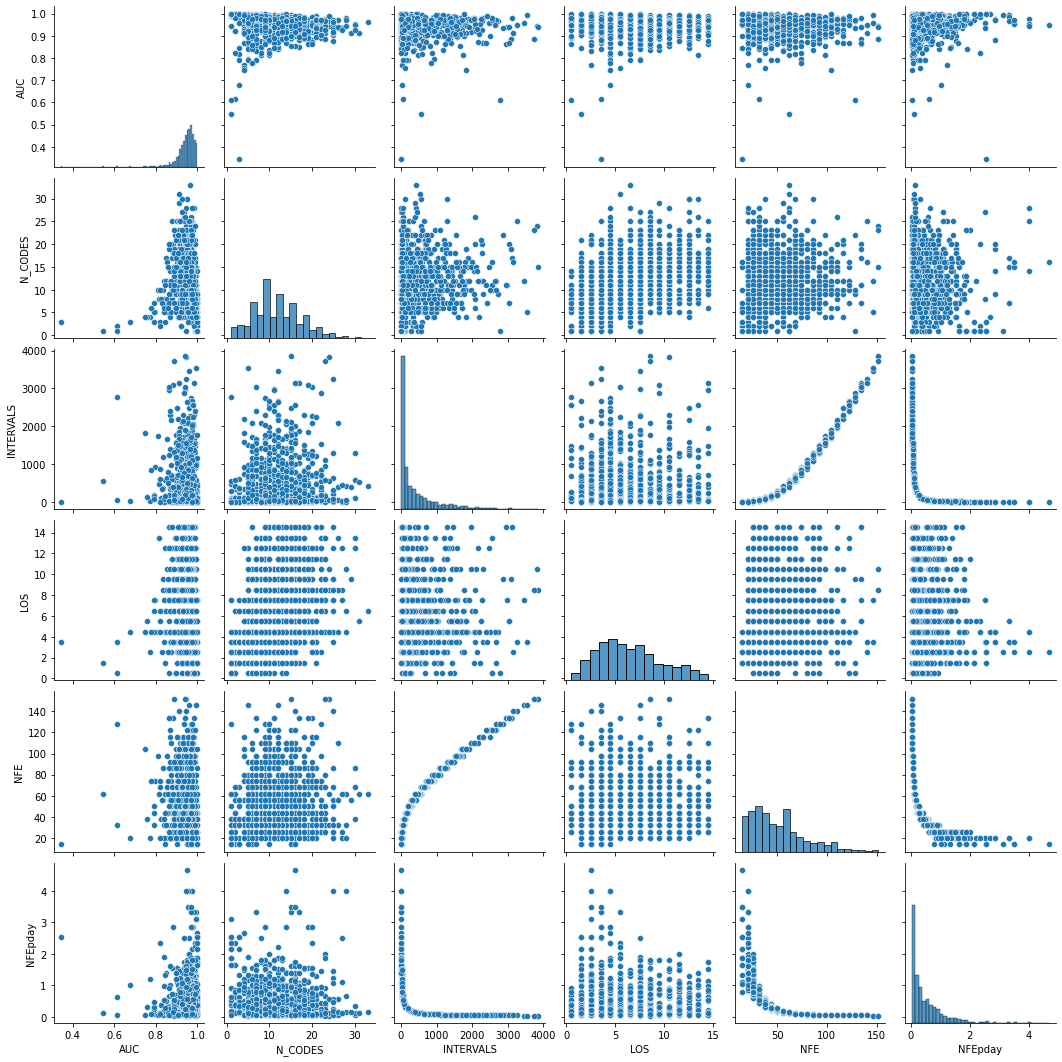

In [20]:
import seaborn as sns
sns.pairplot(icenode_stat)

In [22]:
trajectory = icenode.sample_trajectory(model_state, [10814, 15883, 8734, 23706, 50772, 9555, 9253, 21448, 23577], 0.5)

KeyError: 'd1d'

In [46]:
ccs_codes, ccs_idx = icnode_patient_interface.diag_ccs_history(19842)

In [53]:
import numpy as np
hist_idx = np.array(list(ccs_idx))
hist_idx

array([647, 655, 403, 533, 666, 540, 285,  30,  28, 544, 545, 548, 550,
       423, 552,  41, 422, 555, 556, 557, 564, 439, 568, 441, 442, 338,
       608, 609, 632, 638, 639])

In [40]:
t = trajectory[19842]['t']
d = trajectory[19842]['d']

In [41]:
d.shape

(1099, 727)

In [42]:
d

DeviceArray([[1.84114825e-07, 4.87500643e-07, 1.09947912e-04, ...,
              2.14288782e-04, 6.39104837e-05, 1.38214717e-04],
             [1.84073627e-07, 4.87378088e-07, 1.09971814e-04, ...,
              2.14275482e-04, 6.38985512e-05, 1.38211268e-04],
             [1.84031592e-07, 4.87254681e-07, 1.09995723e-04, ...,
              2.14262298e-04, 6.38865822e-05, 1.38207717e-04],
             ...,
             [3.49542653e-08, 9.25172188e-08, 8.33062513e-05, ...,
              4.00503166e-04, 4.67650752e-05, 1.58451614e-04],
             [3.49575835e-08, 9.25168351e-08, 8.33410668e-05, ...,
              4.00461024e-04, 4.67523969e-05, 1.58440758e-04],
             [3.49608484e-08, 9.25167356e-08, 8.33758677e-05, ...,
              4.00418561e-04, 4.67397731e-05, 1.58429713e-04]],            dtype=float32)

In [54]:
d_hist = d[:, hist_idx]

In [55]:
d_hist.shape

(1099, 31)

In [56]:
import matplotlib.pyplot as plt

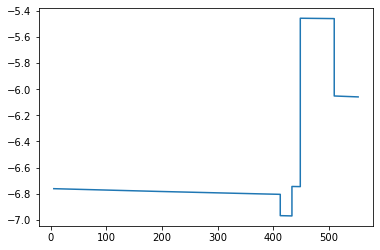

In [86]:
plt.plot(t, np.log(d_hist)[:, 28])

In [78]:
t

DeviceArray([  5.5,   6. ,   6.5, ..., 551.5, 552. , 552.5], dtype=float32)